In [1]:
import dgl
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
import dgl.function as fn
import dgl.nn.pytorch as dglnn
import itertools
from dgl.nn import GraphConv
from dgl.nn import SumPooling
from dgl.nn import DenseGraphConv
from dgl.nn import SAGEConv
import dgl.data

Using backend: pytorch
C:\Users\79776\anaconda3\lib\site-packages\dgl\base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)


In [2]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super().__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [3]:
class SAGE(nn.Module):
    def __init__(self, in_feats, h_feats, n_layers, activation, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.h_feats = h_feats
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, h_feats, 'mean'))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(h_feats, h_feats, 'mean'))
        self.layers.append(dglnn.SAGEConv(h_feats, h_feats, 'mean'))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, g, in_feat):
        h = in_feat
        for l,layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

In [4]:
#for directed graph will be, it will be different?
class DotPredictor(nn.Module): 
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

In [5]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [6]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [7]:
def visualize(labels, g):
    pos = nx.spring_layout(g, seed=1)
    plt.figure(figsize=(18, 18))
    plt.axis('off')
    nx.draw_networkx(g, pos=pos, node_size=30, cmap=plt.get_cmap('coolwarm'), node_color=labels, 
                     edge_color='k', arrows=True, width=0.7, style='dotted', with_labels=False)

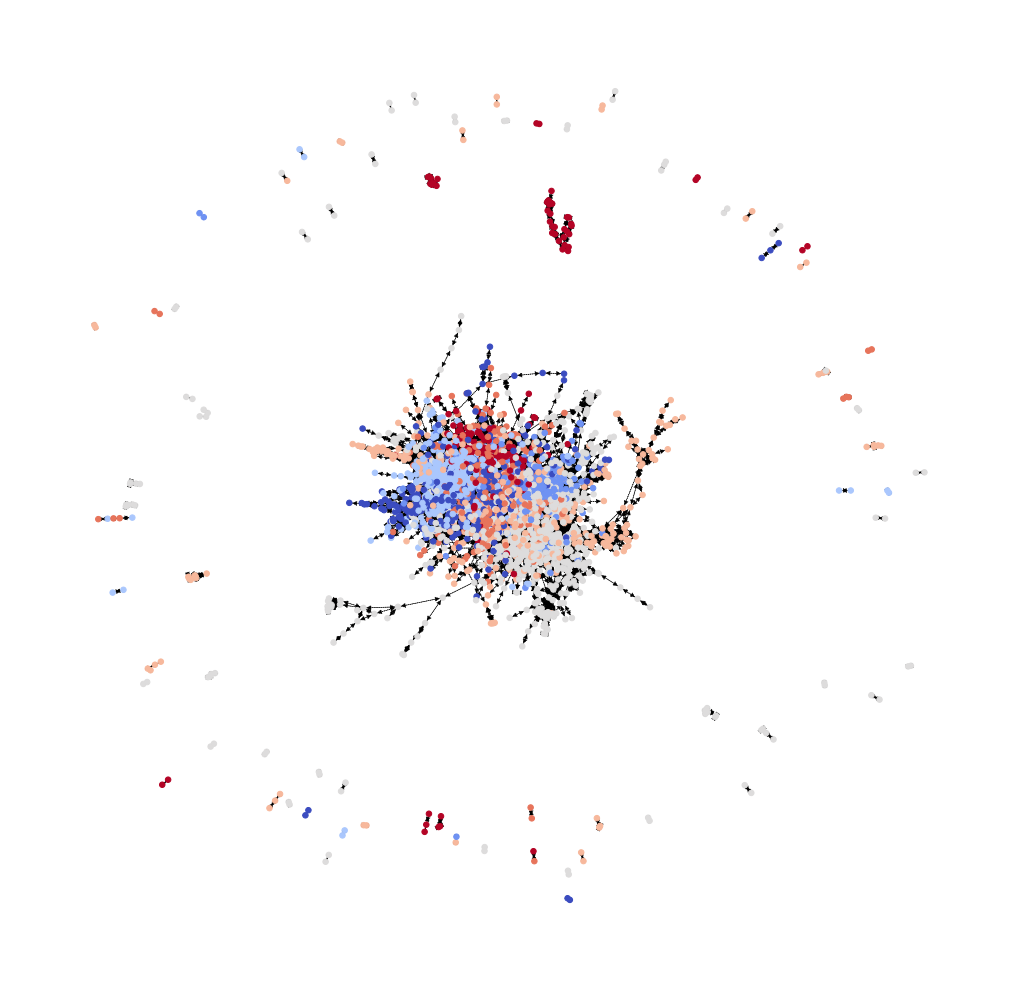

In [8]:
label1 = g.ndata['label']
nx_G1 = g.to_networkx()
    
visualize(label1, nx_G1)

In [9]:
def positive_sample(graph, test_size=0.1):
    u, v = graph.edges()
    eids = np.random.permutation(np.arange(g.number_of_edges())) #random index edges
    test_size_idx = int(len(eids) * test_size) #size positive sample by index

    test_pos_u, test_pos_v = u[eids[:test_size_idx]], v[eids[:test_size_idx]]
    train_pos_u, train_pos_v = u[eids[test_size_idx:]], v[eids[test_size_idx:]]
    
    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
    
    return train_pos_g, test_pos_g

In [10]:
def negative_sample(graph, method='kneighbors', size=g.number_of_nodes(), test_size=int(g.number_of_edges()*0.1)):   
    new_g = graph.to_networkx()
    adj = nx.to_numpy_array(new_g) #adjacency matrix
    
    print(method)
    if method == 'dgl_example':
        adj_neg = 1 - adj - np.eye(g.number_of_nodes())
        neg_u, neg_v = np.where(adj_neg != 0)
        neg_eids = np.random.choice(len(neg_u), g.number_of_edges() // 2) #negative sample random index
        
        test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
        train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
    
    else:
        negs_u = []
        negs_v = []
        negs = []
        nnn = NearestNeighbors(n_neighbors=500, metric='cosine')
        nnn.fit(adj)
        res = nnn.kneighbors(return_distance=False) #top-5 nearest neightbord

        for idx, i in enumerate(res):
            for j in i:
                if not new_g.has_edge(idx, j):
                    negs.append([idx, j])

        negs = np.array(negs)

        for k in range(size):
            temp = negs[np.random.permutation(negs.shape[0])[:graph.number_of_edges()]][0]
            negs_u.append(temp[0])
            negs_v.append(temp[1])
            
        test_neg_u, test_neg_v = negs_u[:test_size], negs_v[:test_size]
        train_neg_u, train_neg_v = negs_u[test_size:], negs_v[test_size:]
    
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())
            
    return train_neg_g, test_neg_g

In [11]:
#print(new_g.edges(1))
#print(new_g.edges)
#print(negs[0:10])
train_pos_g, test_pos_g = positive_sample(g)
train_neg_g, test_neg_g = negative_sample(g, 'dgl_example')

dgl_example


In [12]:
eids = np.random.permutation(np.arange(g.number_of_edges()))
train_g = dgl.remove_edges(g, eids[:int(len(eids) * 0.1)]) #subgraph
print(train_g)

Graph(num_nodes=2708, num_edges=9501,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})


In [13]:
#model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
model = SAGE(train_g.ndata['feat'].shape[1], 20, 4, F.relu, 0.25)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [14]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

all_logits = []
for e in range(100):
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))


from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.7609372735023499
In epoch 5, loss: 0.6159947514533997
In epoch 10, loss: 0.6057606935501099
In epoch 15, loss: 0.5782806277275085
In epoch 20, loss: 0.5255451202392578
In epoch 25, loss: 0.49503782391548157
In epoch 30, loss: 0.45069649815559387
In epoch 35, loss: 0.4353058338165283
In epoch 40, loss: 0.42547714710235596
In epoch 45, loss: 0.4105004668235779
In epoch 50, loss: 0.3889234960079193
In epoch 55, loss: 0.37740302085876465
In epoch 60, loss: 0.37093478441238403
In epoch 65, loss: 0.36287280917167664
In epoch 70, loss: 0.35442817211151123
In epoch 75, loss: 0.35126829147338867
In epoch 80, loss: 0.3399452567100525
In epoch 85, loss: 0.3296823799610138
In epoch 90, loss: 0.32180777192115784
In epoch 95, loss: 0.3166733384132385
AUC 0.8739597044091552


In [15]:
print(pred(train_pos_g, h), len(pred(train_pos_g, h)))
print(h, h[0], len(h[0]))
print(min(h[0]), max(h[0]))

tensor([ 3.1052,  3.3208,  3.1134,  ..., 11.5877,  0.2115,  3.7497],
       grad_fn=<SelectBackward>) 9501
tensor([[ 0.4301, -0.5979,  0.2689,  ..., -0.0982, -0.1512, -0.1944],
        [ 0.0151, -0.1537, -0.2866,  ...,  0.1354, -0.0125,  0.1066],
        [ 0.2214, -0.6590, -0.1413,  ..., -0.1414, -0.1256,  0.2719],
        ...,
        [ 0.2170, -0.2524,  0.0888,  ...,  0.1892,  0.0837,  0.0262],
        [-1.1047,  0.1791, -0.5738,  ..., -0.7887, -0.0808, -0.2644],
        [-1.3819, -0.1486, -0.8641,  ..., -1.1395, -0.0870, -0.1072]],
       grad_fn=<AddBackward0>) tensor([ 0.4301, -0.5979,  0.2689, -0.1666,  0.0860, -0.2984,  0.3648, -0.4380,
        -0.3309,  0.0824,  0.3276,  0.1116,  0.0346,  0.2394,  0.3346, -0.1147,
         0.0026, -0.0982, -0.1512, -0.1944], grad_fn=<SelectBackward>) 20
tensor(-0.5979, grad_fn=<SelectBackward>) tensor(0.4301, grad_fn=<SelectBackward>)


Graph(num_nodes=708, num_edges=591,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})


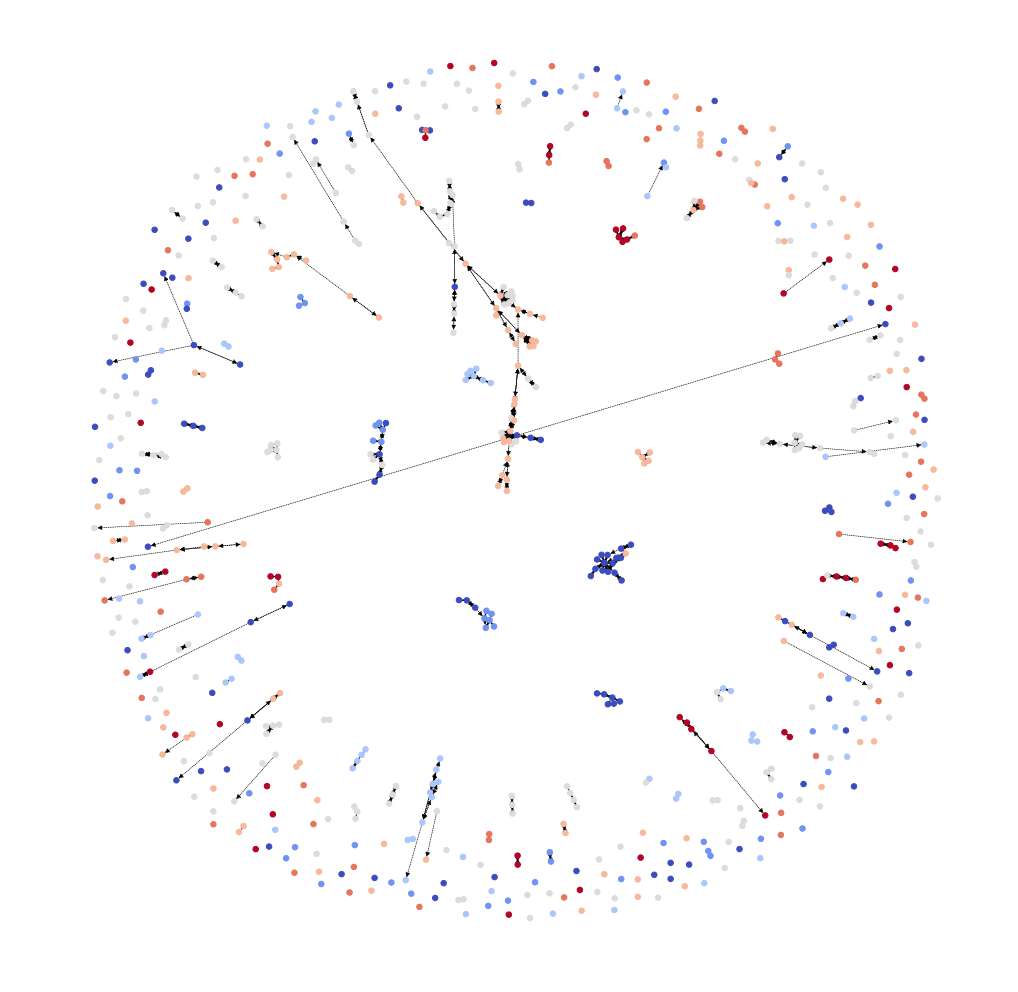

In [16]:
train_g = dgl.remove_edges(g, eids[:1000], ) #subgraph
train_g = dgl.remove_nodes(train_g, range(2000))
print(train_g)

label2 = train_g.ndata['label']
nx_G2 = train_g.to_networkx()

visualize(label2, nx_G2)

In [17]:
'''
negative_sample
def neg_sampl_kneighbors(graph, size):
    new_g = graph.to_networkx()
    adj = nx.to_numpy_array(new_g) #adjacency matrix
    nnn = NearestNeighbors(n_neighbors=500, metric='cosine')
    nnn.fit(adj)
    res = nnn.kneighbors(return_distance=False) #top-5 nearest neightbord
    negs_u = []
    negs_v = []
    negs = []
    for idx, i in enumerate(res):
        for j in i:
            if not new_g.has_edge(idx, j):
                negs.append([idx, j])
    negs = np.array(negs)
    for k in range(size):
        temp = negs[np.random.permutation(negs.shape[0])[:graph.number_of_edges()]][0]
        negs_u.append(temp[0])
        negs_v.append(temp[1])
    return negs_u, negs_v


#########################################################################################
#positive sample for test and train 
eids = np.arange(g.number_of_edges())
print(eids, len(eids))
eids = np.random.permutation(eids)
print(eids, len(eids))
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
print(train_size, test_size)
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    
#########################################################################################
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy()))) #it is positive edges
print((u.numpy(), v.numpy()))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes()) #ununderstandable
print('todense=', adj.todense(), len(adj.todense()))
#print(adj_neg, adj_neg[0], len(adj_neg))
neg_u, neg_v = np.where(adj_neg != 0)
#print('negativ=', neg_u, len(neg_u), neg_v, len(neg_v))

neg_eids = np.random.choice(len(neg_u), g.number_of_edges() // 2) #negative sample
#print(neg_eids, len(neg_eids), g.number_of_edges() // 2)
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]


test_neg_u, test_neg_v = neg_u[:test_size], neg_v[:test_size]
train_neg_u, train_neg_v = neg_u[test_size:], neg_v[test_size:]


train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
print(train_pos_g)
print(train_neg_g)
test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
print(test_pos_g)
print(test_neg_g)
#########################################################################################
a=np.random.permutation([1,2,3, 4, 5]) #example do permutation
for i in a: 
  print(i)
  
u, v = g.edges()
print(g.nodes())
print(g.edges())
print(len(u), len(v))

'''

"\nnegative_sample\ndef neg_sampl_kneighbors(graph, size):\n    new_g = graph.to_networkx()\n    adj = nx.to_numpy_array(new_g) #adjacency matrix\n    nnn = NearestNeighbors(n_neighbors=500, metric='cosine')\n    nnn.fit(adj)\n    res = nnn.kneighbors(return_distance=False) #top-5 nearest neightbord\n    negs_u = []\n    negs_v = []\n    negs = []\n    for idx, i in enumerate(res):\n        for j in i:\n            if not new_g.has_edge(idx, j):\n                negs.append([idx, j])\n    negs = np.array(negs)\n    for k in range(size):\n        temp = negs[np.random.permutation(negs.shape[0])[:graph.number_of_edges()]][0]\n        negs_u.append(temp[0])\n        negs_v.append(temp[1])\n    return negs_u, negs_v\n\n\n#########################################################################################\n#positive sample for test and train \neids = np.arange(g.number_of_edges())\nprint(eids, len(eids))\neids = np.random.permutation(eids)\nprint(eids, len(eids))\ntest_size = int(len(e